## TVB-NEST co-simulation
We demonstrate a multiscale simulation <br> of a reduced Wong-Wang model [1] <br> using TVB [2] for brain region modelled at coarse scale, <br> and NEST [3] for regions modelled as <br> networks of spiking neural populations.

In [1]:
# For interactive plotting:
%matplotlib notebook
! pip uninstall -y tvb
! pip install --upgrade tvb-library hbp-service-client
import time
import numpy as np
from collections import OrderedDict
from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

Requirement already up-to-date: tvb-library in /opt/conda/lib/python3.6/site-packages (2.0)
Requirement already up-to-date: hbp-service-client in /opt/conda/lib/python3.6/site-packages (1.1.1)


## Load structural data
minimally a TVB connectivity

QL_20120814_Connectivity.zip  work
2019-12-12 11:17:11,920 - ERROR - tvb.basic.readers - Could not import tvb_data Python module for default data-set!
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/tvb/basic/readers.py", line 225, in try_get_absolute_path
    module_import = __import__(relative_module, globals(), locals(), ["__init__"])
ModuleNotFoundError: No module named 'tvb_data'


<IPython.core.display.Javascript object>


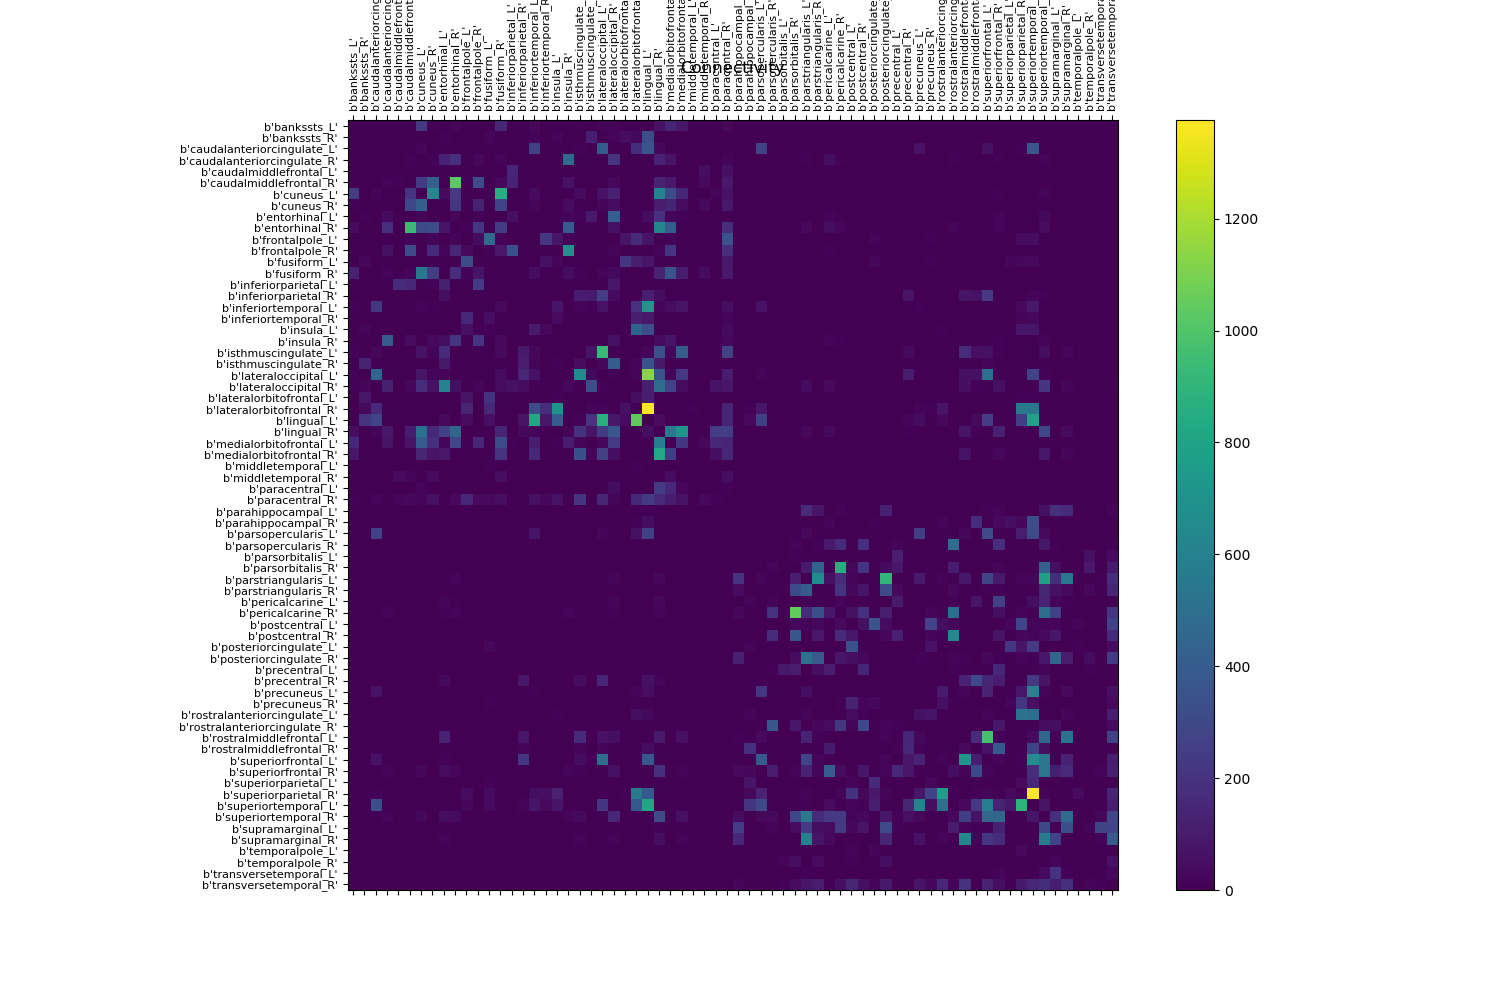

<IPython.core.display.Javascript object>


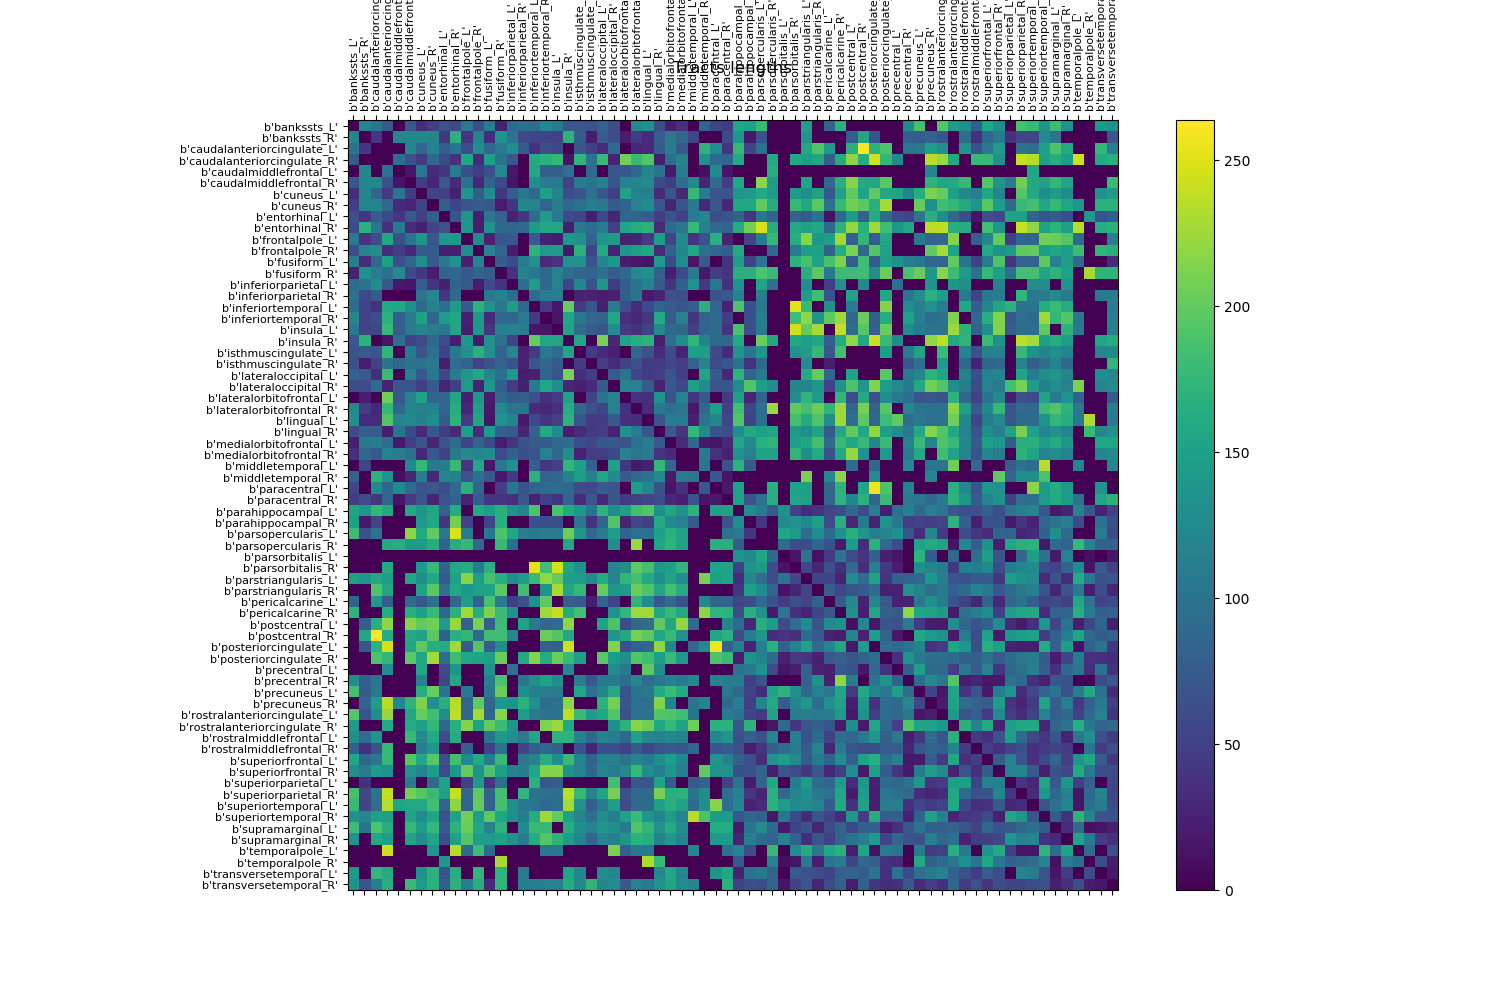

In [2]:
from os.path import join

def download_file(file_name):
    client = get_hbp_service_client()
    COLLAB_PATH = get_collab_storage_path()
    collab_full_path = join(COLLAB_PATH, 'tvb_data', file_name)
    client.storage.download_file(collab_full_path, file_name)
    !ls

download_file("QL_20120814_Connectivity.zip")

from tvb.datatypes.connectivity import Connectivity
connectivity = Connectivity.from_file("QL_20120814_Connectivity.zip")
connectivity.configure()

from matplotlib import pyplot
def plot_tvb_connectivity(connectivity, plot_hinton=False, plot_tracts=True):
        """
        A 2D plot for visualizing the Connectivity.weights matrix
        """
        figsize = (15, 10)
        fontsize = 8

        labels = connectivity.region_labels
        plot_title = connectivity.__class__.__name__
        order = np.arange(connectivity.number_of_regions)
        order_rows = order[:, np.newaxis]
        order_columns = order_rows.T

        if plot_hinton:
            from tvb.simulator.plot.tools import hinton_diagram
            weights_axes = hinton_diagram(connectivity.weights[order_rows, order_columns], num)
            weights_figure = None
        else:
            # weights matrix
            weights_figure = pyplot.figure(num="Connectivity weights", figsize=figsize)
            weights_axes = weights_figure.gca()
            wimg = weights_axes.matshow(connectivity.weights[order_rows, order_columns])
            weights_figure.colorbar(wimg)

        weights_axes.set_title(plot_title)
        weights_axes.set_yticks(np.arange(connectivity.number_of_regions))
        weights_axes.set_yticklabels(list(labels[order]), fontsize=fontsize)
        weights_axes.set_xticks(np.arange(connectivity.number_of_regions))
        weights_axes.set_xticklabels(list(labels[order]), fontsize=fontsize, rotation=90)
        pyplot.ion()
        pyplot.show()

        if plot_tracts:
            # tract lengths matrix too
            tracts_figure = pyplot.figure(num="Tracts lengths", figsize=figsize)
            tracts_axes = tracts_figure.gca()
            timg = tracts_axes.matshow(connectivity.tract_lengths[order_rows, order_columns])
            tracts_axes.set_title("Tracts lengths")
            tracts_figure.colorbar(timg)
            tracts_axes.set_yticks(np.arange(connectivity.number_of_regions))
            tracts_axes.set_yticklabels(list(labels[order]), fontsize=fontsize)
            tracts_axes.set_xticks(np.arange(connectivity.number_of_regions))
            tracts_axes.set_xticklabels(list(labels[order]), fontsize=fontsize, rotation=90)
            pyplot.ion()
            pyplot.show()

plot_tvb_connectivity(connectivity)

## Prepare TVB simulator  
(model, integrator, monitors etc)

# From this step forward won't work in HBP Collab directly right now, it would require that the Notebook tool is updated first.

In [3]:
from tvb_nest.base.simulator import Simulator
from tvb_nest.tvb_models.reduced_wong_wang_exc_io_inh_i import ReducedWongWangExcIOInhI
from tvb.simulator.monitors import Raw  # , Bold, EEG

# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = Simulator()
simulator.model = ReducedWongWangExcIOInhI()

def boundary_fun(state):
    state[state < 0] = 0.0
    state[state > 1] = 1.0
    return state

# Synaptic gating state variables S_e, S_i need to be in the interval [0, 1]
simulator.boundary_fun = boundary_fun
    
simulator.connectivity = connectivity
simulator.integrator.dt = \
    float(int(np.round(simulator.integrator.dt / 
                       config.nest.NEST_MIN_DT))) * config.nest.NEST_MIN_DT
# Some extra monitors for neuroimaging measures:
mon_raw = Raw(period=simulator.integrator.dt)
# mon_bold = Bold(period=2000.)
# mon_eeg = EEG(period=simulator.integrator.dt)
simulator.monitors = (mon_raw, )  # mon_bold, mon_eeg

Build and connect the NEST network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [4]:
# Select the regions for the fine scale modeling with NEST spiking networks
number_of_regions = simulator.connectivity.region_labels.shape[0]
nest_nodes_ids = []  # the indices of fine scale regions modeled with NEST
# We model parahippocampal cortices (left and right) with NEST
for id in range(number_of_regions):
    if simulator.connectivity.region_labels[id].find("hippo") > 0:
        nest_nodes_ids.append(id)
        
from tvb_nest.nest_models_builders.red_ww_exc_io_inh_i \
    import RedWWExcIOInhIBuilder

# Build a NEST network model with the corresponding builder
# Using all default parameters for this example
nest_model_builder = \
    RedWWExcIOInhIBuilder(simulator, nest_nodes_ids, config=config)

# #----Uncomment below to modify the builder by changing the default options:-

# # Common order of neurons' number per population:
# nest_model_builder.populations_order = 100  
# # Spiking populations labels:
# nest_model_builder.populations_names = ["E", "I"]
# # Spiking populations scalings for the number of neurons:
# nest_model_builder.populations_scales = [1.0, 0.7]
# # Some properties for the default synapse to be used:
# nest_model_builder.default_synapse["params"]["rule"] = "fixed_indegree"

# # Connection weights between the distinct populations:
# # Choosing the values resulting from J_N = 150 pA and J_i = 1000 pA [1]
# w_ee = 150.0
# w_ei = -1000.0
# w_ie = 150.0
# w_ii = -1000.0

# # Within region-node connections' weights
# nest_model_builder.population_connectivity_synapses_weights = \
#     np.array([[w_ee, w_ei],  # exc_i -> exc_i, inh_i -> exc_i
#               [w_ie, w_ii]])  # exc_i -> inh_i, inh_i -> inh_i
# nest_model_builder.population_connectivity_synapses_delays = \
#     np.array(nest_model_builder.tvb_dt/4)

# # Among/Between region-node connections
# # Given that w_ee == w_ie = J_N, 
# # and that only the excitatory population of one region-node couples to
# # both excitatory and inhibitory populations of another region-node,
# # we need only one connection type
# nest_model_builder.node_connections = \
#     [{"src_population": "E", "trg_population": ["E", "I"],
#       "model": nest_model_builder.default_synapse["model"],
#       "params": nest_model_builder.default_synapse["params"],
#       "weight": w_ee,  # weight scaling the TVB connectivity weight
#       "delay": 0.0}]  # additional delay to the one of TVB connectivity

# # Creating spike_detector devices to be able to 
# # observe NEST spiking activity:
# connections = OrderedDict({})
# #          label <- target population
# connections["E"] = "E"
# connections["I"] = "I"
# nest_model_builder.output_devices = \
#     [{"model": "spike_detector",
#       "props": config.nest.NEST_OUTPUT_DEVICES_PARAMS_DEF["spike_detector"],
#       "nodes": None, "connections": connections}]

#-----------------------------------------------------------------------------

nest_network = nest_model_builder.build_nest_network()

## Build the TVB-NEST interface

In [5]:
from tvb_nest.interface_builders.red_ww_exc_io_inh_i \
    import RedWWexcIOinhIBuilder

# Build a TVB-NEST interface with all the appropriate connections between the
# TVB and NEST modelled regions
# Using all default parameters for this example
tvb_nest_builder = RedWWexcIOinhIBuilder(simulator, nest_network, 
                                         nest_nodes_ids, config=config)

#------------Modifications to the default options of the builder--------------

# NEST -> TVB:
#
# 1.1. For current transmission from TVB to NEST,
# either choose a NEST dc_generator device:
# tvb_nest_builder.tvb_to_nest_interfaces = \
#    [{"model": "dc_generator", "sign": 1,
# #                      TVB  <-  NEST
#      "connections": {"S_e": ["E", "I"]}}]

# 1.2. or modify directly the external current stimulus parameter:
tvb_nest_builder.tvb_to_nest_interfaces = \
    [{"model": "current", "parameter": "I_e", "sign": 1,
      #                TVB  <-  NEST
      "connections": {"S_e": ["E", "I"]}}]

# 2.1. For spike transmission from TVB to NEST:
# tvb_nest_builder.tvb_to_nest_interfaces = \
#    [{"model": "poisson_generator", "sign": 1,
# #                      TVB  <-  NEST
#      "connections": {"S_e": ["E", "I"]}}]

# NEST -> TVB:
# Use S_e and S_i instead of r_e and r_i
# for transmitting to the TVB state variables directly
connections = OrderedDict()
#            TVB <- NEST
connections["r_e"] = "E"
connections["r_i"] = "I"
tvb_nest_builder.nest_to_tvb_interfaces = \
    [{"model": "spike_detector", "params": {}, "connections": connections}]

#-----------------------------------------------------------------------------

tvb_nest_model = tvb_nest_builder.build_interface()

Configure simulator and simulate

In [6]:
# Configure the simulator with the TVB-NEST interface...
simulator.configure(tvb_nest_interface=tvb_nest_model)
# ...and simulate!
t = time.time()
results = simulator.run(simulation_length=100.0)
print("\nSimulated in %f secs!" % (time.time() - t))

In [7]:
# Gather results in a Timeseries instance
from tvb_timeseries.model.timeseries import Timeseries
# from tvb.datatypes.time_series import TimeSeriesRegion

#   Remove ts_type="Region" this argument too for TVB TimeSeriesRegion
source_ts = \
    Timeseries(  # substitute with TimeSeriesRegion fot TVB like functionality
               data=results[0][1], time=results[0][0],
               connectivity=simulator.connectivity,
               # region_mapping=head.cortical_region_mapping,
               # region_mapping_volume=head.region_volume_mapping,
               labels_ordering=["Time", "Synaptic Gating Variable", 
                                "Region", "Neurons"],
               labels_dimensions=
                    {"Synaptic Gating Variable": ["S_e", "S_i"],
                     "Region": 
                         simulator.connectivity.region_labels.tolist()},
               sample_period=simulator.integrator.dt, ts_type="Region")

## Gather results and plot them

Plot spikes' raster and mean spike rate for NEST regions

In [8]:
# Plot spikes and mean field spike rates
rates, max_rate, spike_detectors, time = \
    nest_network.compute_mean_spike_rates(
        spike_counts_kernel_width=simulator.integrator.dt,  # ms
        spike_counts_kernel_overlap=0.0, time=source_ts.time)
plotter.plot_spikes(spike_detectors, time, rates=rates, max_rate=max_rate,
                    title='Population spikes and mean spike rate', 
                    figsize=config.figures.NOTEBOOK_SIZE);

Plot time series

In [9]:
# Plot timeseries
# Add _tvb from the function names 
# if source_ts is a TVB TimeSeriesRegion object
plotter.plot_timeseries(source_ts.S_e, 
                        title="Excitatory population time series", 
                        figsize=config.figures.NOTEBOOK_SIZE);

In [10]:
plotter.plot_timeseries(source_ts.S_i, 
                        title="Inhibitory population time series", 
                        figsize=config.figures.NOTEBOOK_SIZE);

In [11]:
# For raster plot:
plotter.plot_timeseries_raster(source_ts, 
                               title="Region Time Series Raster", 
                               figsize=config.figures.NOTEBOOK_SIZE);

Interactive time series plot

In [12]:
# ...interactively as well
# Use this to skip completely the tvb-scripts plotter
# from tvb.simulator.plot.timeseries_interactive import TimeSeriesInteractive
# tvb_plotter = TimeSeriesInteractive(time_series=source_ts._tvb)
# tvb_plotter.configure()
# tvb_plotter.show()
plotter.plot_timeseries_interactive(source_ts, 
                                    figsize=config.figures.NOTEBOOK_SIZE)

## References

1 Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide, <br>
  Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>
  
2 Deco Gustavo, Ponce Alvarez Adrian, Dante Mantini, Gian Luca Romani, <br>
  Patric Hagmann and Maurizio Corbetta. <br>
  Resting-State Functional Connectivity Emerges from Structurally and <br>
  Dynamically Shaped Slow Linear Fluctuations. <br>
  The Journal of Neuroscience 32(27), 11239-11252, 2013.<br>

3 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>